# MMSegmentation Tutorial

## 1. Install MMSegmentation
This step may take several minutes.

We use PyTorch 1.12 and CUDA 11.3 for this tutorial. You may install other versions by change the version number in pip install command.

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Install PyTorch
#!pip install pytorch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0 cudatoolkit=11.3 -c pytorch
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
# Install mim
!pip install -U openmim
# Install mmengine
!mim install mmengine
# Install MMCV
!mim install 'mmcv == 2.0.0rc4'


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 MB 5.7 MB/s eta 0:00:00


In [ ]:
!rm -rf mmsegmentation
!git clone -b main https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 16493, done.
remote: Total 16493 (delta 0), reused 0 (delta 0), pack-reused 16493 (from 1)
Receiving objects: 100% (16493/16493), 44.23 MiB | 19.57 MiB/s, done.
Resolving deltas: 100% (11495/11495), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.1+cu113 True
1.2.2


In [ ]:
!pip install ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00


## 2. Check GPU availability

In [ ]:
!nvidia-smi

Fri Oct 25 15:40:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 3. Import libraries for MMSegmentation

In [ ]:
%cd /content/mmsegmentation

from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset
from mmengine import Config

from mmengine.runner import Runner

# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
from PIL import Image

/content/mmsegmentation


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 4. Mount Drive to load datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## 5. Instalar librerías necesarias para visualización de entrenamiento y feature maps

In [ ]:
!pip install wandb
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 6. Training settings

In [ ]:
# define dataset root and directory for images and annotations
train_data_root = '/content/drive/MyDrive/crack_segmentation_dataset/train/'
val_data_root = '/content/drive/MyDrive/crack_segmentation_dataset/test/'
train_img_dir = val_img_dir = test_img_dir = 'images'
train_ann_dir = val_ann_dir = test_ann_dir = 'mmsegm_masks'

# define class and palette for better visualization
classes = ('background', 'crack')
palette = [[0,0,0], [128,0,0]]

In [ ]:
# define the model configuration
# Los nombres de configuración en MMSegmentation incluyen diversos campos, por ejemplo:
# El nombre fcn_r50-d8_4xb4-20k_voc12aug-512x512 se desglosa como sigue:
#     pspnet es el tipo de modelo (https://github.com/open-mmlab/mmsegmentation/tree/main/configs/pspnet)
#     r50 es el backbone usado (ResNet50 en este caso)
#     d8_4xb2 es otra característica específica del modelo, para esta tarea no tienen necesidad de saber que significa
#     40k es la cantidad por defecto de iteraciones por las cuales será entrenado el modelo (20k = 20.000 iteraciones)
#     cityscapes es el dataset original en el que se entreno el modelo (fue preentrenado)
#     769x769 es el tamaño de las imágenes del dataset anterior, que se parecen bastante a 448x448 que son las dimensiones
#             de las imágenes de esta experiencia
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-769x769.py')

In [ ]:
# Esta sección se utiliza para definir el tipo de datos que se hará ingresar a los modelos, definiendo el tipo de archivo tanto de las imágenes como del ground truth
# Me encargué de que las imágenes y máscaras fueran ambas de tipo .jpg
# Otra anotación importante es que las máscaras originales de grietas eran binarias pero del estilo (0 -> background, 255 -> grieta), pero MMSegmentation acepta máscaras del estilo (0,1,2...n),
# donde cada entero indica el número de la clase a la cual pertenece cierto pixel, con un máximo de n clases, donde la clase 0 es el background.
# Es por esto que convertí las máscaras a esta codificación, es decir, (0 -> background, 1 -> grieta) para facilitarles la Tarea, pero deben tener en consideración que no siempre será así.
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class CrackDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.jpg', **kwargs)

In [ ]:
# Modify dataset type and path
cfg.dataset_type = 'CrackDataset'
cfg.data_root = train_data_root

cfg.train_dataloader.batch_size = 2

cfg.model.decode_head.num_classes = 2 # Usaremos solo 2 clases, las que son background y crack
cfg.model.auxiliary_head.num_classes = 2

# Original images are of 448x448

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    #dict(type='RandomResize', scale=(224, 224), ratio_range=(0.5, 2.0), keep_ratio=True),
    #dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    #dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    #dict(type='Resize', scale=(224, 224), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]

cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = train_data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=train_img_dir, seg_map_path=train_ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'train_small.txt' # or 'train.txt'
cfg.train_dataloader.num_workers = 1

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = val_data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=val_img_dir, seg_map_path=val_ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'test_small.txt' # or 'test.txt'
cfg.val_dataloader.num_workers = 1

cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.data_root = val_data_root
cfg.test_dataloader.dataset.data_prefix = dict(img_path=test_img_dir, seg_map_path=test_ann_dir)
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader.dataset.ann_file = 'test_small.txt' # or 'test.txt'
cfg.test_dataloader.num_workers = 1


# Load the pretrained weights (if we would have it)
#cfg.load_from = 'path/to/checkpoint'

cfg.train_cfg.val_interval = 960 # Normalmente este valor corresponde a la cantidad de imagenes en la particion de entrenamiento,
# es decir, se evalua cada vez que se recorren todos los datos.
cfg.train_cfg.max_iters = cfg.train_cfg.val_interval * 6 # Normalmente se llama época a una vuelta entera a los datos, entonces
# acá definimos que el modelo se entrene por 2 épocas de forma manual. EXISTEN FORMAS DE HACERLO AUTOMÁTICO EN MMSEGMENTATION
# PERO NO ES EL OBJETIVO DE LA TAREA. Notar que la configuración originalmente tomaba 20.000 iteraciones, ahora las variamos a 11.520
cfg.val_evaluator.iou_metrics = ['mIoU']
cfg.default_hooks.checkpoint.save_best = "mIoU"
cfg.default_hooks.checkpoint.rule = "greater"
cfg.default_hooks.checkpoint.interval = 0

cfg.work_dir = '/content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_{}_iters'.format(cfg.train_cfg.max_iters)

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

In [ ]:
cfg.visualizer

{'type': 'SegLocalVisualizer',
 'vis_backends': [{'type': 'LocalVisBackend'}],
 'name': 'visualizer'}

In [ ]:
# Todo esto lo pueden ver en el tutorial de MMSegmentation que explica la visualizaciones de feature maps y entrenamiento
# https://mmsegmentation.readthedocs.io/en/latest/user_guides/visualization_feature_map.html
vis_backends=[
              dict(type='LocalVisBackend'),
              dict(type='WandbVisBackend', init_kwargs=dict(
                                                            project='CrackSegmentation',
                                                            name='run_1'))
              ]
cfg.visualizer = dict(type='SegLocalVisualizer', vis_backends=vis_backends, name='visualizer')

In [ ]:
cfg.visualizer

{'type': 'SegLocalVisualizer',
 'vis_backends': [{'type': 'LocalVisBackend'},
  {'type': 'WandbVisBackend',
   'init_kwargs': {'project': 'CrackSegmentation', 'name': 'run_1'}}],
 'name': 'visualizer'}

## 7. Train

Gracias a la magia de MMSegmentation, para entrenar un modelo una vez tienes una configuración lista, basta con ejecutar las siguientes 3 líneas de código (en realidad son 2, la última limpia la memoria caché de la GPU para no tener problemas al querer evaluar o entrenar denuevo).

In [ ]:
runner = Runner.from_cfg(cfg)

# start training
runner.train()

torch.cuda.empty_cache()

10/25 15:43:20 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 1.12.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lucas-orellana-j (lucas-orellana-j-universidad-de-chile). Use `wandb login --relogin` to force relogin


/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


10/25 15:43:30 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
10/25 15:43:30 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


10/25 15:43:32 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
10/25 15:43:32 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
10/25 15:43:33 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c


Downloading: "https://download.openmmlab.com/pretrain/third_party/resnet50_v1c-2cccc1ad.pth" to /root/.cache/torch/hub/checkpoints/resnet50_v1c-2cccc1ad.pth


10/25 15:43:49 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

10/25 15:43:49 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/25 15:43:49 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
10/25 15:43:49 - mmengine - INFO - Checkpoints will be saved to /content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters.


/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (6, 6) is `x+1` and out size (97, 97) is `nx+1`
  warnings.warn(


10/25 15:46:23 - mmengine - INFO - Iter(train) [  50/5760]  lr: 9.9891e-03  eta: 4:51:32  time: 1.7112  data_time: 0.2166  memory: 9942  loss: 0.0669  decode.loss_ce: 0.0468  decode.acc_seg: 91.4150  aux.loss_ce: 0.0201  aux.acc_seg: 91.4150
10/25 15:48:11 - mmengine - INFO - Iter(train) [ 100/5760]  lr: 9.9779e-03  eta: 4:06:38  time: 3.7973  data_time: 2.2520  memory: 6911  loss: 0.0648  decode.loss_ce: 0.0467  decode.acc_seg: 98.2868  aux.loss_ce: 0.0181  aux.acc_seg: 98.2868
10/25 15:49:38 - mmengine - INFO - Iter(train) [ 150/5760]  lr: 9.9668e-03  eta: 3:37:07  time: 1.8078  data_time: 0.2674  memory: 6911  loss: 0.0550  decode.loss_ce: 0.0392  decode.acc_seg: 92.6860  aux.loss_ce: 0.0158  aux.acc_seg: 92.6860
10/25 15:51:09 - mmengine - INFO - Iter(train) [ 200/5760]  lr: 9.9557e-03  eta: 3:23:34  time: 1.7346  data_time: 0.1801  memory: 6911  loss: 0.0491  decode.loss_ce: 0.0343  decode.acc_seg: 95.1765  aux.loss_ce: 0.0148  aux.acc_seg: 95.1854
10/25 15:52:32 - mmengine - INFO

/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (3, 3) is `x+1` and out size (56, 56) is `nx+1`
  warnings.warn(
/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (56, 56) is `x+1` and out size (448, 448) is `nx+1`
  warnings.warn(


10/25 16:12:44 - mmengine - INFO - Iter(val) [ 50/169]    eta: 0:02:32  time: 0.8824  data_time: 0.7899  memory: 6911  
10/25 16:13:31 - mmengine - INFO - Iter(val) [100/169]    eta: 0:01:16  time: 0.9166  data_time: 0.8223  memory: 884  
10/25 16:14:20 - mmengine - INFO - Iter(val) [150/169]    eta: 0:00:20  time: 1.0789  data_time: 0.9842  memory: 884  
10/25 16:14:35 - mmengine - INFO - per class results:
10/25 16:14:35 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.44 | 99.95 |
|   crack    |  8.99 |  9.11 |
+------------+-------+-------+
10/25 16:14:35 - mmengine - INFO - Iter(val) [169/169]    aAcc: 96.4600  mIoU: 52.7200  mAcc: 54.5300  data_time: 0.9371  time: 1.0351
10/25 16:14:36 - mmengine - INFO - The best checkpoint with 52.7200 mIoU at 960 iter is saved to best_mIoU_iter_960.pth.


/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (6, 6) is `x+1` and out size (97, 97) is `nx+1`
  warnings.warn(


10/25 16:15:50 - mmengine - INFO - Exp name: pspnet_r50-d8_4xb2-40k_cityscapes-769x769_20241025_154319
10/25 16:15:50 - mmengine - INFO - Iter(train) [1000/5760]  lr: 9.7772e-03  eta: 2:18:26  time: 1.5587  data_time: 0.0096  memory: 6911  loss: 0.0323  decode.loss_ce: 0.0226  decode.acc_seg: 97.1015  aux.loss_ce: 0.0097  aux.acc_seg: 97.0464
10/25 16:17:08 - mmengine - INFO - Iter(train) [1050/5760]  lr: 9.7660e-03  eta: 2:16:20  time: 1.5700  data_time: 0.0057  memory: 6911  loss: 0.0322  decode.loss_ce: 0.0229  decode.acc_seg: 96.0205  aux.loss_ce: 0.0093  aux.acc_seg: 95.6755
10/25 16:18:27 - mmengine - INFO - Iter(train) [1100/5760]  lr: 9.7549e-03  eta: 2:14:18  time: 1.5689  data_time: 0.0059  memory: 6911  loss: 0.0347  decode.loss_ce: 0.0240  decode.acc_seg: 98.3917  aux.loss_ce: 0.0106  aux.acc_seg: 98.5192
10/25 16:19:45 - mmengine - INFO - Iter(train) [1150/5760]  lr: 9.7437e-03  eta: 2:12:20  time: 1.5721  data_time: 0.0054  memory: 6911  loss: 0.0268  decode.loss_ce: 0.01

/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (3, 3) is `x+1` and out size (56, 56) is `nx+1`
  warnings.warn(
/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (56, 56) is `x+1` and out size (448, 448) is `nx+1`
  warnings.warn(


10/25 16:40:00 - mmengine - INFO - Iter(val) [ 50/169]    eta: 0:00:08  time: 0.0742  data_time: 0.0018  memory: 6911  
10/25 16:40:04 - mmengine - INFO - Iter(val) [100/169]    eta: 0:00:05  time: 0.0810  data_time: 0.0121  memory: 884  
10/25 16:40:09 - mmengine - INFO - Iter(val) [150/169]    eta: 0:00:01  time: 0.0753  data_time: 0.0032  memory: 884  
10/25 16:40:10 - mmengine - INFO - per class results:
10/25 16:40:10 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.44 | 99.94 |
|   crack    |  9.08 |  9.23 |
+------------+-------+-------+
10/25 16:40:10 - mmengine - INFO - Iter(val) [169/169]    aAcc: 96.4500  mIoU: 52.7600  mAcc: 54.5800  data_time: 0.0100  time: 0.0867
10/25 16:40:10 - mmengine - INFO - The previous best checkpoint /content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters/best_mIoU_iter_960.pth is removed
10/25 16:40:20 - mmengine - INFO - The best checkpoint with 52.

/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (6, 6) is `x+1` and out size (97, 97) is `nx+1`
  warnings.warn(


10/25 16:41:08 - mmengine - INFO - Iter(train) [1950/5760]  lr: 9.5648e-03  eta: 1:45:49  time: 1.5881  data_time: 0.0068  memory: 6911  loss: 0.0253  decode.loss_ce: 0.0178  decode.acc_seg: 98.1565  aux.loss_ce: 0.0075  aux.acc_seg: 98.0202
10/25 16:42:26 - mmengine - INFO - Exp name: pspnet_r50-d8_4xb2-40k_cityscapes-769x769_20241025_154319
10/25 16:42:26 - mmengine - INFO - Iter(train) [2000/5760]  lr: 9.5536e-03  eta: 1:44:16  time: 1.5775  data_time: 0.0101  memory: 6911  loss: 0.0271  decode.loss_ce: 0.0190  decode.acc_seg: 98.0095  aux.loss_ce: 0.0081  aux.acc_seg: 97.4961
10/25 16:43:45 - mmengine - INFO - Iter(train) [2050/5760]  lr: 9.5424e-03  eta: 1:42:44  time: 1.5692  data_time: 0.0074  memory: 6911  loss: 0.0354  decode.loss_ce: 0.0243  decode.acc_seg: 98.6585  aux.loss_ce: 0.0111  aux.acc_seg: 98.2504
10/25 16:45:04 - mmengine - INFO - Iter(train) [2100/5760]  lr: 9.5312e-03  eta: 1:41:14  time: 1.5722  data_time: 0.0066  memory: 6911  loss: 0.0303  decode.loss_ce: 0.02

/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (3, 3) is `x+1` and out size (56, 56) is `nx+1`
  warnings.warn(
/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (56, 56) is `x+1` and out size (448, 448) is `nx+1`
  warnings.warn(


10/25 17:05:35 - mmengine - INFO - Iter(val) [ 50/169]    eta: 0:00:08  time: 0.0743  data_time: 0.0017  memory: 6911  
10/25 17:05:39 - mmengine - INFO - Iter(val) [100/169]    eta: 0:00:05  time: 0.0746  data_time: 0.0019  memory: 884  
10/25 17:05:42 - mmengine - INFO - Iter(val) [150/169]    eta: 0:00:01  time: 0.0817  data_time: 0.0142  memory: 884  
10/25 17:05:44 - mmengine - INFO - per class results:
10/25 17:05:44 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.68 | 99.79 |
|   crack    | 18.63 | 19.62 |
+------------+-------+-------+
10/25 17:05:44 - mmengine - INFO - Iter(val) [169/169]    aAcc: 96.7100  mIoU: 57.6500  mAcc: 59.7100  data_time: 0.0034  time: 0.0755
10/25 17:05:44 - mmengine - INFO - The previous best checkpoint /content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters/best_mIoU_iter_1920.pth is removed
10/25 17:05:45 - mmengine - INFO - The best checkpoint with 57

/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (6, 6) is `x+1` and out size (97, 97) is `nx+1`
  warnings.warn(


10/25 17:06:17 - mmengine - INFO - Iter(train) [2900/5760]  lr: 9.3518e-03  eta: 1:18:00  time: 1.5736  data_time: 0.0063  memory: 6911  loss: 0.0187  decode.loss_ce: 0.0129  decode.acc_seg: 98.2828  aux.loss_ce: 0.0057  aux.acc_seg: 98.2828
10/25 17:07:36 - mmengine - INFO - Iter(train) [2950/5760]  lr: 9.3406e-03  eta: 1:16:35  time: 1.5793  data_time: 0.0091  memory: 6911  loss: 0.0247  decode.loss_ce: 0.0173  decode.acc_seg: 98.2051  aux.loss_ce: 0.0074  aux.acc_seg: 98.1821
10/25 17:08:54 - mmengine - INFO - Exp name: pspnet_r50-d8_4xb2-40k_cityscapes-769x769_20241025_154319
10/25 17:08:54 - mmengine - INFO - Iter(train) [3000/5760]  lr: 9.3294e-03  eta: 1:15:10  time: 1.5719  data_time: 0.0068  memory: 6911  loss: 0.0294  decode.loss_ce: 0.0209  decode.acc_seg: 94.8905  aux.loss_ce: 0.0086  aux.acc_seg: 94.6543
10/25 17:10:13 - mmengine - INFO - Iter(train) [3050/5760]  lr: 9.3182e-03  eta: 1:13:46  time: 1.5742  data_time: 0.0061  memory: 6911  loss: 0.0180  decode.loss_ce: 0.01

/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (3, 3) is `x+1` and out size (56, 56) is `nx+1`
  warnings.warn(
/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (56, 56) is `x+1` and out size (448, 448) is `nx+1`
  warnings.warn(


10/25 17:30:59 - mmengine - INFO - Iter(val) [ 50/169]    eta: 0:00:08  time: 0.0736  data_time: 0.0018  memory: 6911  
10/25 17:31:03 - mmengine - INFO - Iter(val) [100/169]    eta: 0:00:05  time: 0.0746  data_time: 0.0017  memory: 884  
10/25 17:31:06 - mmengine - INFO - Iter(val) [150/169]    eta: 0:00:01  time: 0.0772  data_time: 0.0069  memory: 884  
10/25 17:31:08 - mmengine - INFO - per class results:
10/25 17:31:08 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.42 | 99.94 |
|   crack    |  8.36 |  8.48 |
+------------+-------+-------+
10/25 17:31:08 - mmengine - INFO - Iter(val) [169/169]    aAcc: 96.4300  mIoU: 52.3900  mAcc: 54.2100  data_time: 0.0029  time: 0.0750
10/25 17:31:23 - mmengine - INFO - Iter(train) [3850/5760]  lr: 9.1383e-03  eta: 0:51:35  time: 1.5622  data_time: 0.0094  memory: 6911  loss: 0.0166  decode.loss_ce: 0.0116  decode.acc_seg: 98.5023  aux.loss_ce: 0.0050  aux.acc_se

/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (6, 6) is `x+1` and out size (97, 97) is `nx+1`
  warnings.warn(


10/25 17:57:53 - mmengine - INFO - Iter(train) [4850/5760]  lr: 8.9130e-03  eta: 0:24:26  time: 1.5667  data_time: 0.0062  memory: 6911  loss: 0.0236  decode.loss_ce: 0.0166  decode.acc_seg: 99.1218  aux.loss_ce: 0.0070  aux.acc_seg: 99.0125
10/25 17:59:11 - mmengine - INFO - Iter(train) [4900/5760]  lr: 8.9017e-03  eta: 0:23:05  time: 1.5804  data_time: 0.0091  memory: 6911  loss: 0.0133  decode.loss_ce: 0.0094  decode.acc_seg: 99.2175  aux.loss_ce: 0.0039  aux.acc_seg: 99.2265
10/25 18:00:30 - mmengine - INFO - Iter(train) [4950/5760]  lr: 8.8904e-03  eta: 0:21:44  time: 1.5773  data_time: 0.0078  memory: 6911  loss: 0.0224  decode.loss_ce: 0.0157  decode.acc_seg: 98.4397  aux.loss_ce: 0.0067  aux.acc_seg: 98.5581
10/25 18:01:49 - mmengine - INFO - Exp name: pspnet_r50-d8_4xb2-40k_cityscapes-769x769_20241025_154319
10/25 18:01:49 - mmengine - INFO - Iter(train) [5000/5760]  lr: 8.8791e-03  eta: 0:20:23  time: 1.5729  data_time: 0.0071  memory: 6911  loss: 0.0160  decode.loss_ce: 0.01

/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (3, 3) is `x+1` and out size (56, 56) is `nx+1`
  warnings.warn(
/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (56, 56) is `x+1` and out size (448, 448) is `nx+1`
  warnings.warn(


10/25 18:21:51 - mmengine - INFO - Iter(val) [ 50/169]    eta: 0:00:09  time: 0.0806  data_time: 0.0079  memory: 6911  
10/25 18:21:55 - mmengine - INFO - Iter(val) [100/169]    eta: 0:00:05  time: 0.0744  data_time: 0.0017  memory: 884  
10/25 18:21:58 - mmengine - INFO - Iter(val) [150/169]    eta: 0:00:01  time: 0.0746  data_time: 0.0018  memory: 884  
10/25 18:22:00 - mmengine - INFO - per class results:
10/25 18:22:00 - mmengine - INFO - 
+------------+-------+------+
|   Class    |  IoU  | Acc  |
+------------+-------+------+
| background | 96.84 | 99.8 |
|   crack    | 22.55 | 23.7 |
+------------+-------+------+
10/25 18:22:00 - mmengine - INFO - Iter(val) [169/169]    aAcc: 96.8800  mIoU: 59.7000  mAcc: 61.7500  data_time: 0.0046  time: 0.0768
10/25 18:22:00 - mmengine - INFO - The previous best checkpoint /content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters/best_mIoU_iter_4800.pth is removed
10/25 18:22:01 - mmengine - INFO - The best checkpoint with 59.7000 

aAcc,▁▁▅▁▆█
aux.acc_seg,▁▆▇▅▆▆▆▇█▇█▇▆▅▅▆▇▇▄▆█▆▇▇▇▇▇▇▇▇▇▆███▆▆▇▇▇
aux.loss_ce,█▇▄▃▄▃▃▂▄▃▃▂▃▂▃▂▄▂▂▁▃▁▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▁
data_time,▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
decode.acc_seg,▆▆▆▇▁▅▆▆▇▆▆▄█▇▆▅▄▂▆▄▃▅▂▆▇█▇█▇▇█▄▄▆▅▆▅▅▃▇
decode.loss_ce,█▇▆▄▃▄▃▃▃▃▃▃▃▅▂▃▄▃▂▃▁▂▂▃▁▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁
iter,▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
loss,█▇▅▄▅▄▃▃▃▃▃▃▃▂▅▁▂▃▂▃▁▃▁▂▃▂▂▂▂▂▁▂▂▂▂▂▂▁▁▂
lr,█████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁
mAcc,▁▁▆▁▇█
mIoU,▁▁▆▁▇█


## 8. Inference with trained model

No es necesario utilizar esta sección pero lo dejo por si quieren visualizar el output de su modelo con alguna imagen particular.

In [ ]:
from glob import glob
glob('/content/drive/MyDrive/crack_segmentation_dataset/test/images/**')

['/content/drive/MyDrive/crack_segmentation_dataset/test/images/Eugen_Muller_8980a_25_22_747_752.jpg',
 '/content/drive/MyDrive/crack_segmentation_dataset/test/images/Rissbilder_for_Florian_9S6A2831_14_1354_3612_3768.jpg',
 '/content/drive/MyDrive/crack_segmentation_dataset/test/images/Rissbilder_for_Florian_9S6A2800_191_3241_2390_2435.jpg',
 '/content/drive/MyDrive/crack_segmentation_dataset/test/images/GAPS384_train_1117_1_1.jpg',
 '/content/drive/MyDrive/crack_segmentation_dataset/test/images/Rissbilder_for_Florian_9S6A2802_631_103_2560_2012.jpg',
 '/content/drive/MyDrive/crack_segmentation_dataset/test/images/GAPS384_train_1366_541_1.jpg',
 '/content/drive/MyDrive/crack_segmentation_dataset/test/images/DeepCrack_11215-15.jpg',
 '/content/drive/MyDrive/crack_segmentation_dataset/test/images/Rissbilder_for_Florian_9S6A2805_565_1400_2938_2247.jpg',
 '/content/drive/MyDrive/crack_segmentation_dataset/test/images/Rissbilder_for_Florian_9S6A2795_244_2755_3348_2948.jpg',
 '/content/drive/

In [ ]:
img = '/content/drive/MyDrive/crack_segmentation_dataset/test/images/Volker_DSC01664_168_876_1650_1486.jpg'
#hard_img = '/content/drive/MyDrive/crack_segmentation_dataset/test/images/Sylvie_Chambon_303.jpg'
mask = img.replace('images', 'mmsegm_masks')

Loads checkpoint by local backend from path: /content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters/best_mIoU_iter_5760.pth


/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (3, 3) is `x+1` and out size (56, 56) is `nx+1`
  warnings.warn(
/content/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (56, 56) is `x+1` and out size (448, 448) is `nx+1`
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


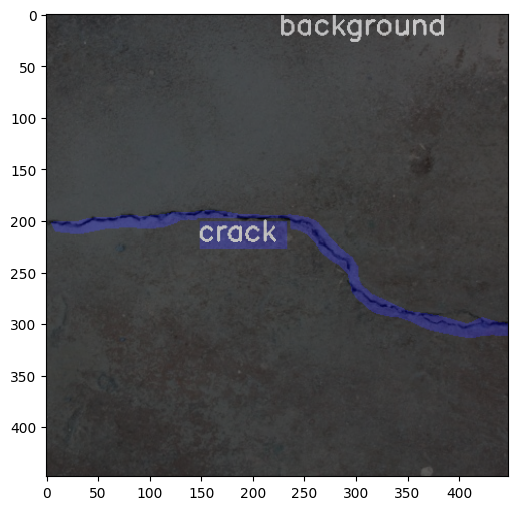

In [ ]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
#checkpoint_path = 'path/to/your/best/checkpoint.pth'
checkpoint_path = '/content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters/best_mIoU_iter_5760.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread(img)
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))
plt.show()

## 9. Definiendo la visualización de feature maps con wandb

In [ ]:
# Con esto pueden recorrer el directorio de los runs que tienen
import glob
glob.glob('/content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters/**')

['/content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters/iter_5760.pth',
 '/content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters/best_mIoU_iter_5760.pth',
 '/content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters/last_checkpoint',
 '/content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters/pspnet_r50-d8_4xb2-40k_cityscapes-769x769.py',
 '/content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters/20241025_154319']

In [ ]:
!python feature_map_visual.py \
"{img}" \
 /content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters/pspnet_r50-d8_4xb2-40k_cityscapes-769x769.py \
/content/crack_segmentation_dataset/work_dirs/pspnet_r50_+_5760_iters/best_mIoU_iter_5760.pth \
--gt_mask "{mask}"

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/content/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
Loads checkpoint by local backend from path: